In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install dask-ml --quiet
!pip install dask --quiet
!pip install kmodes --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 12.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df_init = pd.read_csv('/content/drive/MyDrive/df_base.csv', low_memory = False)
#df_init['fecha_suceso'] = pd.to_datetime(df_init['fecha_suceso'])
iter_csv = pd.read_csv('/content/drive/MyDrive/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[ pd.to_datetime(chunk['fecha_suceso']).dt.year  >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


Acotaremos el ejercicio a los distritos donde más casos hubieron

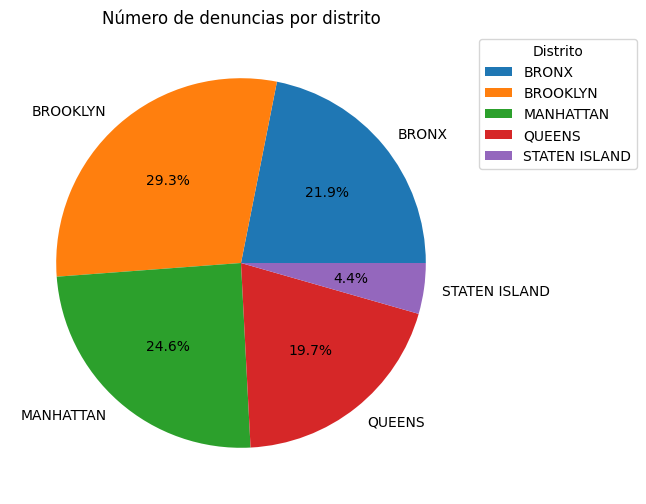

In [ ]:
distritos_counts = df.groupby(['distrito']).size()

# Crear un gráfico de torta
plt.figure(figsize=(6, 6))
distritos_counts.plot.pie(autopct='%1.1f%%')
plt.title('Número de denuncias por distrito')
plt.legend(title='Distrito', labels=distritos_counts.index, bbox_to_anchor=(1, 1))
plt.show()

## MANHATTAN

In [ ]:
df_manhattan = df[df.distrito == 'MANHATTAN'].copy()
df_manhattan.reset_index(inplace = True, drop = True)
df_manhattan['direccion_suceso'] = df_manhattan['direccion_suceso'].astype('object')

In [ ]:
df_manhattan.drop(columns= ['fecha_suceso', 'fecha_denuncia', 'num_denuncia', 'direccion_suceso', 'distrito', 'diff_dias_hecho_denuncia', 'nivel_ofensa', 'delito_completado_interrumpido'], inplace = True)

Separamos coordenadas

In [ ]:
df_manhattan['latitud'] = df_manhattan.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[0]))
df_manhattan['longitud'] = df_manhattan.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[1]))
df_manhattan.drop(columns= ['geoespacial'], inplace = True)
df_manhattan.head()

,hora_suceso,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,latitud,longitud
0,Noche,Policia,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,jueves,primavera,abril,40.810877,-73.941064
1,Noche,Policia,25-44,WHITE,Masculino,UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,sabado,verano,julio,40.759310,-73.994706
2,Noche,Policia,<18,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,sabado,otono,diciembre,40.764536,-73.970728
3,Mañana,Transito,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,extorsion,necesidades diarias,lunes,primavera,abril,40.804384,-73.937422
4,Noche,Policia,25-44,BLACK,Desconocido,25-44,BLACK,Masculino,delitos_graves,lugares publicos,miercoles,otono,octubre,40.803905,-73.952037


In [ ]:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_manhattan.select_dtypes('number')
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_cols), columns = num_cols.columns.tolist())
df_manhattan_ready = pd.concat([df_manhattan.drop(columns = num_cols.columns.tolist()), scaled], axis = 1)
df_manhattan_ready_sample = df_manhattan_ready.sample(frac = 0.05, replace = True, random_state=1234)

## **1ra iteración:** de 2016 a 2019
- Sin reducción de de dimensionalidad y aplicación de KMeans y Spectral Clustering.

## **2da iteración:** De 2016 a 2019 y distrito con mayor número de casos
- Sin reducción de dimensionalidad y KModes.

### 1.1.1 Sin reducción de dimensionalidad y aplicación de KMeans.

Método del codo

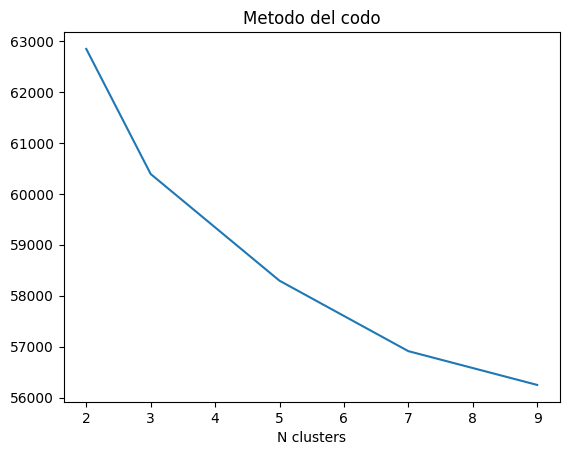

In [ ]:
from sklearn.metrics import silhouette_score  
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
sample = df_manhattan_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()


### Cohesión y Separabilidad con diferentes numero de clusters
- **Calinski-Harabasz:** cuanto mayor sea el valor del índice  se considera que el clustering es mejor.

- **Silhoutte Score:** Un valor cercano a 1 indica que las muestras están bien asignadas a sus clusters y están alejadas de los otros clusters vecinos. Un valor cercano a 0 indica que las muestras están en o cerca del límite de decisión entre dos clusters vecinos. Un valor cercano a -1 indica que las muestras pueden haber sido asignadas incorrectamente a sus clusters y que están más cerca de los otros clusters vecinos.

In [ ]:
from sklearn import metrics
sample = df_manhattan_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
metrics_df_general = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(X, labels)
  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(X, labels)
  metrics_df = pd.DataFrame({'Metodo': ['KMeans'],
                           'k':[k],
                           'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general = metrics_df_general.append(metrics_df, ignore_index=True)
metrics_df_general

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,2746.653442,0.103252
1,KMeans,3,2418.787910,0.106804
2,KMeans,5,1716.989560,0.085804
3,KMeans,7,1316.076073,0.075724
4,KMeans,9,1007.873576,0.084520


### Centroides con KMeans y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 

In [ ]:
centroides_manhattan = pd.DataFrame(centroids, columns = pd.get_dummies(df_manhattan_ready_sample).columns.tolist())
centroides_manhattan.reset_index(inplace = True, drop = False)
centroides_manhattan.rename(columns = {'index':'cluster'}, inplace =True)
centroides_manhattan

,cluster,latitud,longitud,hora_suceso_Madrugada,hora_suceso_Mañana,hora_suceso_Noche,hora_suceso_Tarde,jurisdiccion_encargada_Externas,jurisdiccion_encargada_Otras,jurisdiccion_encargada_Policia,jurisdiccion_encargada_Transito,jurisdiccion_encargada_Vivienda,grupo_edad_sospechoso_25-44,grupo_edad_sospechoso_45-64,grupo_edad_sospechoso_<18,grupo_edad_sospechoso_UNKNOWN,raza_sospechoso_AMERICAN INDIAN/ALASKAN NATIVE,raza_sospechoso_ASIAN / PACIFIC ISLANDER,raza_sospechoso_BLACK,raza_sospechoso_UNKNOWN,raza_sospechoso_WHITE,sexo_sospechoso_Desconocido,sexo_sospechoso_Femenino,sexo_sospechoso_Masculino,grupo_edad_victima_25-44,grupo_edad_victima_45-64,grupo_edad_victima_<18,grupo_edad_victima_UNKNOWN,raza_victima_AMERICAN INDIAN/ALASKAN NATIVE,raza_victima_ASIAN / PACIFIC ISLANDER,raza_victima_BLACK,raza_victima_UNKNOWN,raza_victima_WHITE,sexo_victima_Femenino,sexo_victima_Masculino,sexo_victima_Transgenero,tipo_crimen_armas_drogas,tipo_crimen_crimenes_sexuales,tipo_crimen_delitos_graves,tipo_crimen_extorsion,tipo_crimen_incidentes_menores,tipo_crimen_otros_crimenes,lugar_Otros,lugar_diversion y turismo,lugar_lugares publicos,lugar_lugares solitarios,lugar_necesidades diarias,dia_suceso_domingo,dia_suceso_jueves,dia_suceso_lunes,dia_suceso_martes,dia_suceso_miercoles,dia_suceso_sabado,dia_suceso_viernes,estacion_suceso_invierno,estacion_suceso_otono,estacion_suceso_primavera,estacion_suceso_verano,mes_suceso_abril,mes_suceso_agosto,mes_suceso_diciembre,mes_suceso_febrero,mes_suceso_julio,mes_suceso_junio,mes_suceso_marzo,mes_suceso_mayo,mes_suceso_noviembre,mes_suceso_octubre,mes_suceso_septiembre
0,0,0.590578,0.244513,0.146333,0.166890,0.270527,0.416251,0.016421,0.015692,0.823866,0.070429,0.073592,0.279406,0.129668,0.021774,0.569152,0.001338,0.020800,0.375502,0.364797,0.237562,0.350079,0.115314,0.534606,0.000000,0.000243,0.000000,0.999757,0.000000,0.000730,0.000851,0.997202,0.001216,0.006690,0.010339,0.982970,0.152293,0.017394,0.016300,0.585574,0.207274,0.021165,0.032478,0.510157,0.328184,0.030288,0.098893,0.111422,0.159226,0.128208,0.143292,0.158861,0.137818,0.161173,0.233427,0.252281,0.249970,0.264323,0.081012,0.085878,0.154118,0.089162,0.088919,0.090135,0.068605,0.078823,0.093906,0.079917,0.089527
1,1,0.602880,0.249786,0.144951,0.213249,0.283600,0.358200,0.002931,0.008208,0.905760,0.032537,0.050564,0.003078,0.001905,0.000879,0.994137,0.000293,0.001905,0.010113,0.977722,0.009966,0.948263,0.020959,0.030778,0.460501,0.250916,0.027554,0.261029,0.007914,0.106551,0.244174,0.080903,0.560457,0.475158,0.523963,0.000879,0.001026,0.087938,0.067566,0.705994,0.132933,0.004543,0.034735,0.205775,0.658655,0.018027,0.082808,0.125458,0.141580,0.144365,0.136450,0.137183,0.151253,0.163711,0.227466,0.249744,0.249744,0.273047,0.079291,0.087938,0.169134,0.073135,0.091162,0.091748,0.068445,0.078704,0.088671,0.077825,0.093947
2,2,0.629185,0.267608,0.179302,0.196550,0.294504,0.329643,0.004505,0.008367,0.791222,0.046595,0.149311,0.418587,0.143004,0.046982,0.391427,0.003990,0.034754,0.545373,0.068349,0.347535,0.016991,0.229116,0.753894,0.479598,0.232591,0.063715,0.224096,0.007852,0.087527,0.388081,0.055863,0.460677,0.564809,0.434805,0.000386,0.004891,0.325911,0.308276,0.177758,0.156648,0.026516,0.033338,0.131420,0.720813,0.022654,0.091775,0.149826,0.144678,0.132578,0.139658,0.144034,0.145450,0.143777,0.227829,0.257562,0.249324,0.265285,0.079676,0.092419,0.160381,0.076844,0.089072,0.087399,0.070408,0.082250,0.090874,0.086884,0.083795


In [ ]:
manhattan_kmeans_sin_reduccion = df_manhattan_ready_sample.copy()
manhattan_kmeans_sin_reduccion['clusters'] = kmeans.labels_

### Análisis de clusters en KMeans sin reducción

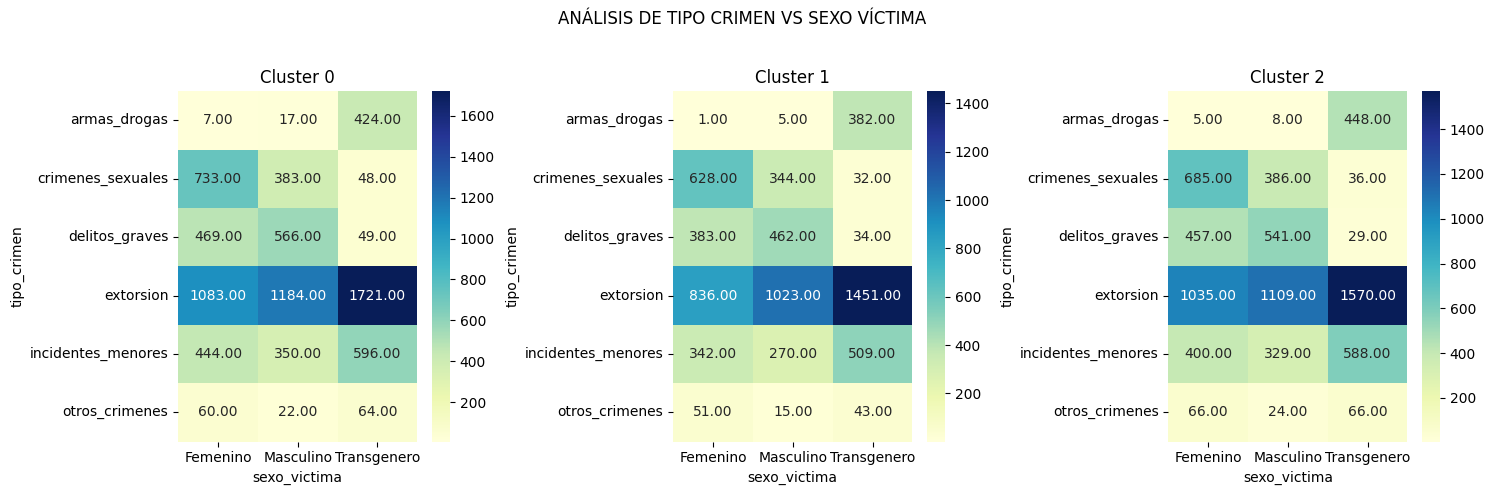

In [ ]:
manhattan_cluster0 = manhattan_kmeans_sin_reduccion[manhattan_kmeans_sin_reduccion['clusters']==0]
manhattan_cluster1 = manhattan_kmeans_sin_reduccion[manhattan_kmeans_sin_reduccion['clusters']==1]
manhattan_cluster2 = manhattan_kmeans_sin_reduccion[manhattan_kmeans_sin_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster0['tipo_crimen'], manhattan_cluster0['sexo_victima'])
ct1 = pd.crosstab(manhattan_cluster1['tipo_crimen'], manhattan_cluster1['sexo_victima'])
ct2 = pd.crosstab(manhattan_cluster2['tipo_crimen'], manhattan_cluster2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

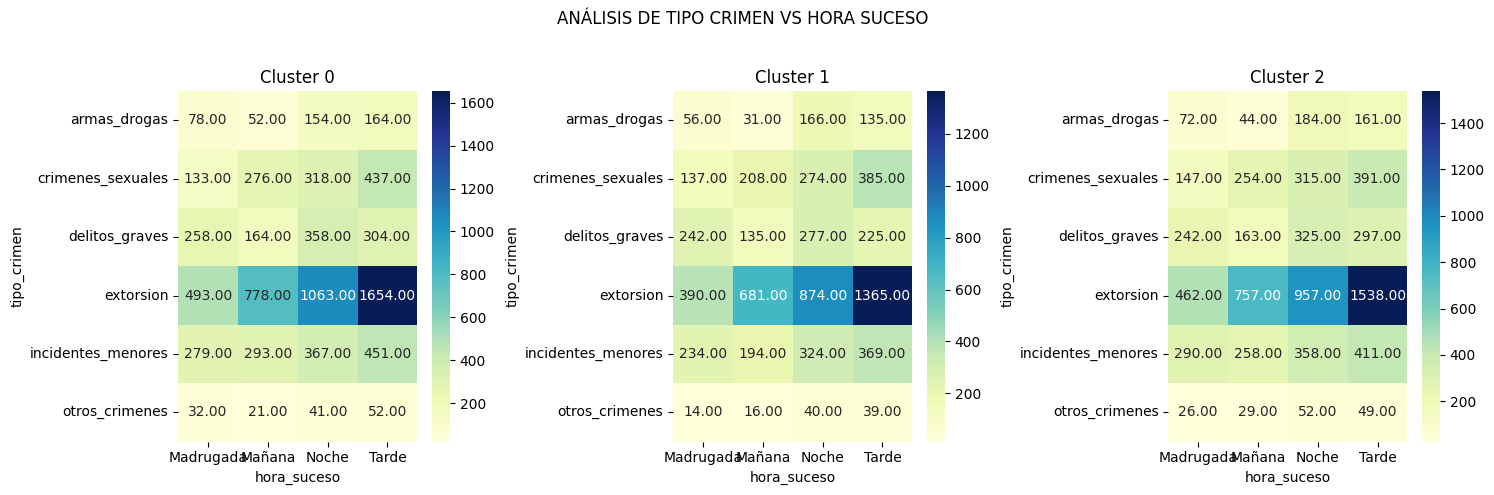

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(manhattan_cluster0['tipo_crimen'], manhattan_cluster0['hora_suceso'])
ct1 = pd.crosstab(manhattan_cluster1['tipo_crimen'], manhattan_cluster1['hora_suceso'])
ct2 = pd.crosstab(manhattan_cluster2['tipo_crimen'], manhattan_cluster2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

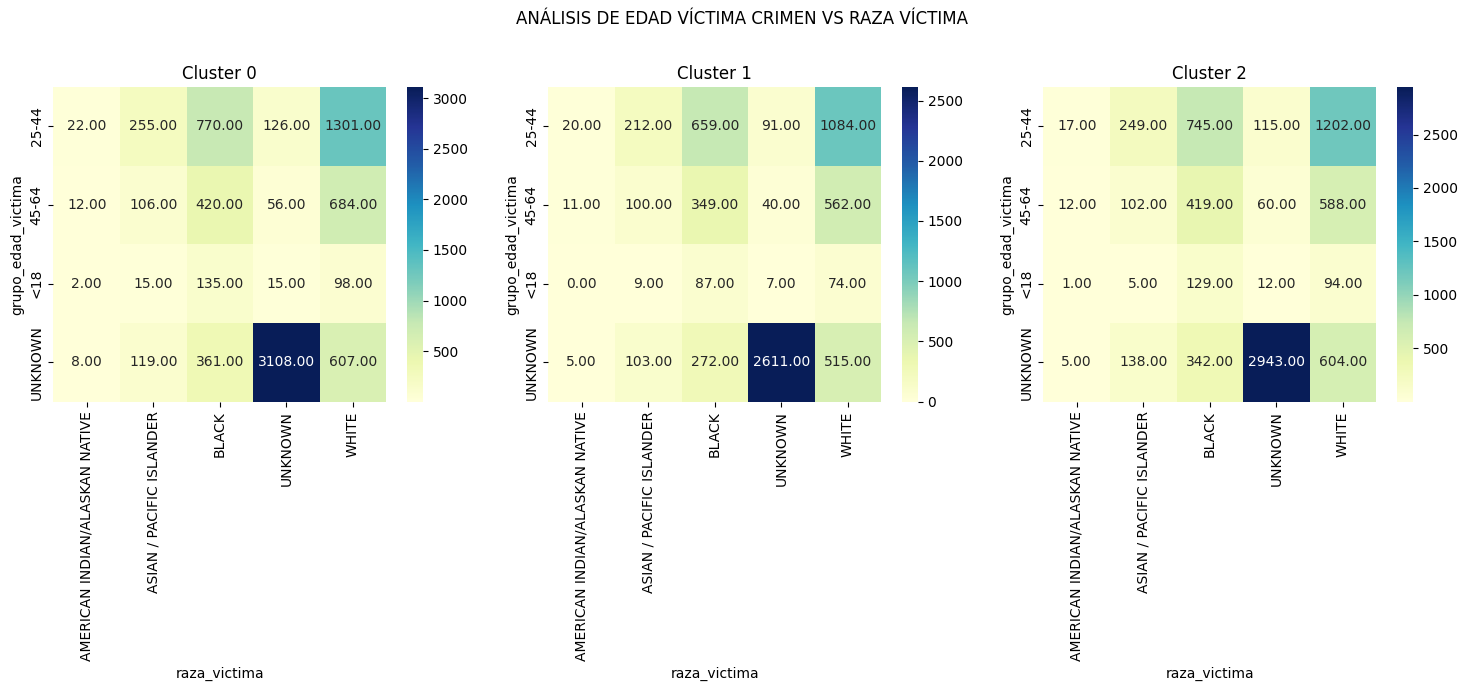

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster0['grupo_edad_victima'], manhattan_cluster0['raza_victima'])
ct1 = pd.crosstab(manhattan_cluster1['grupo_edad_victima'], manhattan_cluster1['raza_victima'])
ct2 = pd.crosstab(manhattan_cluster2['grupo_edad_victima'], manhattan_cluster2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in manhattan_kmeans_sin_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    display(manhattan_kmeans_sin_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'}))
    print('\n')

Variable hora_suceso:


,clusters,hora_suceso,casos
0,0,Madrugada,1273
1,0,Mañana,1584
2,0,Noche,2301
3,0,Tarde,3062
4,1,Madrugada,1073
5,1,Mañana,1265
6,1,Noche,1955
7,1,Tarde,2518
8,2,Madrugada,1239
9,2,Mañana,1505




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos
0,0,Externas,63
1,0,Otras,90
2,0,Policia,6865
3,0,Transito,436
4,0,Vivienda,766
5,1,Externas,64
6,1,Otras,71
7,1,Policia,5734
8,1,Transito,338
9,1,Vivienda,604




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos
0,0,25-44,2004
1,0,45-64,777
2,0,<18,194
3,0,UNKNOWN,5245
4,1,25-44,1690
5,1,45-64,666
6,1,<18,157
7,1,UNKNOWN,4298
8,2,25-44,1876
9,2,45-64,747




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,15
1,0,ASIAN / PACIFIC ISLANDER,151
2,0,BLACK,2643
3,0,UNKNOWN,3696
4,0,WHITE,1715
5,1,AMERICAN INDIAN/ALASKAN NATIVE,14
6,1,ASIAN / PACIFIC ISLANDER,145
7,1,BLACK,2214
8,1,UNKNOWN,3061
9,1,WHITE,1377




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos
0,0,Desconocido,3408
1,0,Femenino,1042
2,0,Masculino,3770
3,1,Desconocido,2839
4,1,Femenino,860
5,1,Masculino,3112
6,2,Desconocido,3233
7,2,Femenino,969
8,2,Masculino,3580




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos
0,0,25-44,2474
1,0,45-64,1278
2,0,<18,265
3,0,UNKNOWN,4203
4,1,25-44,2066
5,1,45-64,1062
6,1,<18,177
7,1,UNKNOWN,3506
8,2,25-44,2328
9,2,45-64,1181




Variable raza_victima:


,clusters,raza_victima,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,44
1,0,ASIAN / PACIFIC ISLANDER,495
2,0,BLACK,1686
3,0,UNKNOWN,3305
4,0,WHITE,2690
5,1,AMERICAN INDIAN/ALASKAN NATIVE,36
6,1,ASIAN / PACIFIC ISLANDER,424
7,1,BLACK,1367
8,1,UNKNOWN,2749
9,1,WHITE,2235




Variable sexo_victima:


,clusters,sexo_victima,casos
0,0,Femenino,2796
1,0,Masculino,2522
2,0,Transgenero,2902
3,1,Femenino,2241
4,1,Masculino,2119
5,1,Transgenero,2451
6,2,Femenino,2648
7,2,Masculino,2397
8,2,Transgenero,2737




Variable tipo_crimen:


,clusters,tipo_crimen,casos
0,0,armas_drogas,448
1,0,crimenes_sexuales,1164
2,0,delitos_graves,1084
3,0,extorsion,3988
4,0,incidentes_menores,1390
5,0,otros_crimenes,146
6,1,armas_drogas,388
7,1,crimenes_sexuales,1004
8,1,delitos_graves,879
9,1,extorsion,3310




Variable lugar:


,clusters,lugar,casos
0,0,Otros,279
1,0,diversion y turismo,2367
2,0,lugares publicos,4596
3,0,lugares solitarios,191
4,0,necesidades diarias,787
5,1,Otros,243
6,1,diversion y turismo,2009
7,1,lugares publicos,3802
8,1,lugares solitarios,159
9,1,necesidades diarias,598




Variable dia_suceso:


,clusters,dia_suceso,casos
0,0,domingo,1070
1,0,jueves,1222
2,0,lunes,1128
3,0,martes,1113
4,0,miercoles,1224
5,0,sabado,1180
6,0,viernes,1283
7,1,domingo,880
8,1,jueves,1011
9,1,lunes,892




Variable estacion_suceso:


,clusters,estacion_suceso,casos
0,0,invierno,1924
1,0,otono,2092
2,0,primavera,2040
3,0,verano,2164
4,1,invierno,1520
5,1,otono,1774
6,1,primavera,1697
7,1,verano,1820
8,2,invierno,1797
9,2,otono,1913




Variable mes_suceso:


,clusters,mes_suceso,casos
0,0,abril,649
1,0,agosto,729
2,0,diciembre,1350
3,0,febrero,661
4,0,julio,738
5,0,junio,723
6,0,marzo,581
7,0,mayo,668
8,0,noviembre,729
9,0,octubre,695


### 1.2 Con reducción de dimensionalidad y aplicación de KMeans.

In [ ]:
from dask_ml.decomposition import PCA

dummies = pd.get_dummies(df_manhattan_ready_sample, dtype ='int')
# crear matriz Dask
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 

# crear objeto PCA
pca = PCA(n_components=X.shape[1])

# ajustar el modelo
pca.fit(X)

PCA(n_components=68)

In [ ]:
pca.explained_variance_ratio_[:40].sum(axis = 0)

0.9735270579758901

In [ ]:
pca = PCA(n_components=40)
X_PCA =pca.fit_transform(X)
#X_PCA = X_PCA.compute() 

In [ ]:
X_PCA_ok = pd.DataFrame(X_PCA, columns = ['component'+str(column) for column in range(X_PCA.shape[1])])
X_PCA_ok.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,1.133757,-0.936732,-1.153235,0.394397,-0.122922,0.244308,-1.251563,-0.109698,0.308834,-0.245372,-0.181567,0.168921,-0.110049,0.389489,-0.237585,-0.520450,-0.051321,0.841591,0.283403,-0.109259,-0.062975,-0.081939,-0.242557,-0.299738,-0.730420,-0.185799,-0.337401,-0.013547,0.157720,0.009524,-0.012526,-0.014702,-0.051338,0.093324,0.019491,0.009409,-0.152472,0.020204,0.049726,0.083004
1,-1.436235,0.471034,0.516884,0.504041,0.247417,0.325137,0.049138,-1.485529,0.195914,-0.271397,0.402885,0.437309,0.135937,0.201001,0.255477,0.100720,-0.432451,-0.208520,-0.067205,0.461761,-0.757745,-0.174817,-0.427418,-0.262468,-0.121628,-0.164590,0.474411,0.189287,-0.319596,-0.015193,0.062548,0.041536,-0.050037,0.050489,-0.019850,-0.045575,0.109243,-0.193342,-0.004885,0.285555
2,-1.126572,0.248778,0.445494,0.733925,0.248792,0.574231,0.567911,-0.771365,-0.645251,-0.117298,0.657867,0.055815,0.458002,-0.603705,-0.228679,-0.047496,0.928473,-0.377231,0.975105,-0.016392,-0.124715,-0.088566,-0.524883,0.348659,-0.513965,0.461030,0.080298,-0.909802,0.339685,0.059296,-0.093141,0.016661,0.012083,0.050107,0.101702,0.070039,0.314861,-0.169020,-0.188148,-0.052340
3,-1.789964,-0.038285,-0.758981,0.589717,0.488069,0.229394,-0.163814,0.728552,-0.181740,0.171702,-0.813441,0.257691,0.177286,-0.215435,0.066569,0.558285,0.186222,-0.125394,-0.075648,0.793553,0.251769,-0.426231,-0.294133,-0.220500,-0.579237,0.029156,0.061212,-0.503809,0.718846,-0.020714,-0.069505,0.033031,0.026808,0.011928,0.053765,0.089448,0.057131,-0.057357,-0.045348,-0.175701
4,0.417488,0.363366,1.089394,0.268600,-1.181886,-0.063205,-0.150236,0.520089,0.017502,0.025932,-0.859596,-0.379192,0.175440,-0.390907,1.090097,0.031579,0.223671,0.869877,0.133952,-0.053027,-0.040194,-0.094013,-0.322580,-0.384939,0.711672,-0.428854,-0.339841,0.754744,0.542259,-0.004082,0.058900,-0.421768,-0.249103,-0.308516,0.474891,-0.300202,0.326209,0.323203,-0.260130,-0.104774


Según el método del codo, cuántos cluster serían una elección óptima?

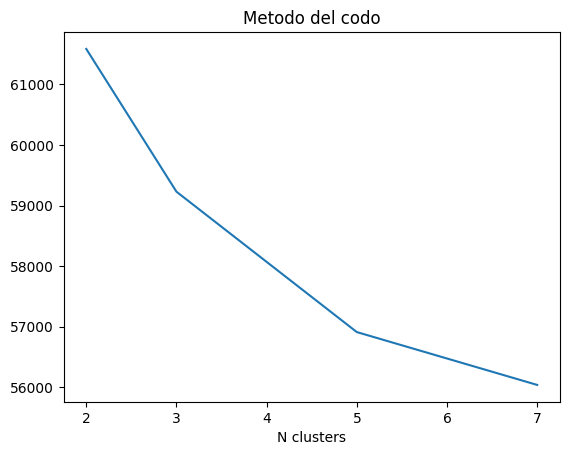

In [ ]:
n_clusters = [2, 3, 5, 7]

km = []

for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k, random_state = 1234)
  kmeans.fit(X_PCA_ok)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()

### Calinski-Harabasz Index y Silhouette Coefficient para n clusters en KMeans con PCA

In [ ]:
metrics_df_general_pca = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
n_clusters = [2,3,5,7,9]
km = []
sample = X_PCA_ok.sample(frac=0.3)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KMeans_PCA'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_pca = metrics_df_general_pca.append(metrics_df, ignore_index=True)

metrics_df_general_pca

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans_PCA,2,801.849735,0.100205
1,KMeans_PCA,3,756.083284,0.110207
2,KMeans_PCA,5,531.685108,0.088195
3,KMeans_PCA,7,417.828148,0.083962
4,KMeans_PCA,9,330.911165,0.058828


### Centroides con KMeans y PCA y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X_PCA_ok)
centroids = kmeans.cluster_centers_ 
labels_pca = kmeans.labels_ 

In [ ]:
centroides_mahattan_pca = pd.DataFrame(centroids, columns = X_PCA_ok.columns.tolist())
centroides_mahattan_pca.reset_index(inplace = True, drop = False)
centroides_mahattan_pca.rename(columns = {'index':'cluster'}, inplace =True)
centroides_mahattan_pca

,cluster,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0,0.639324,-0.874646,0.103953,0.019880,-0.011318,0.015560,-0.013494,0.003705,0.005687,-0.017295,0.009442,0.039809,-0.045238,-0.010450,-0.003455,-0.001857,-0.081404,-0.000098,-0.004375,-0.006127,0.001349,-0.009468,-0.009901,-0.009804,0.017136,0.009636,-0.012122,-0.016143,0.025591,0.000431,-0.001291,0.000009,0.000104,0.002632,0.001041,0.005524,-0.006018,-0.003285,0.001715,0.000033
1,1,0.280490,1.082407,-0.083701,-0.011734,-0.026533,0.012174,0.007153,0.005247,0.019887,-0.036648,-0.008425,-0.072850,0.078416,0.012846,-0.014100,-0.007172,0.055458,0.012353,0.004413,-0.005349,0.015905,0.004408,-0.026672,0.018120,0.010126,-0.006216,0.016910,0.026589,0.000538,-0.003333,-0.000730,-0.007628,-0.004313,-0.015962,-0.004932,-0.005327,0.022116,-0.008676,-0.000985,0.004652
2,2,-1.483545,-0.018448,-0.060591,-0.017557,0.056391,-0.043577,0.013051,-0.013656,-0.037490,0.080729,-0.004355,0.033786,-0.032291,-0.000099,0.025596,0.013190,0.061538,-0.017088,0.001307,0.017935,-0.024521,0.010010,0.054167,-0.008570,-0.043408,-0.007772,-0.002921,-0.009576,-0.044453,0.003921,0.003223,0.010639,0.005847,0.017804,0.005111,-0.001992,-0.020618,0.017729,-0.001554,-0.006554


In [ ]:
manhattan_kmeans_con_reduccion = df_manhattan_ready_sample.copy()
manhattan_kmeans_con_reduccion['clusters'] = labels_pca

### Análisis de clusters en KMeans con reducción

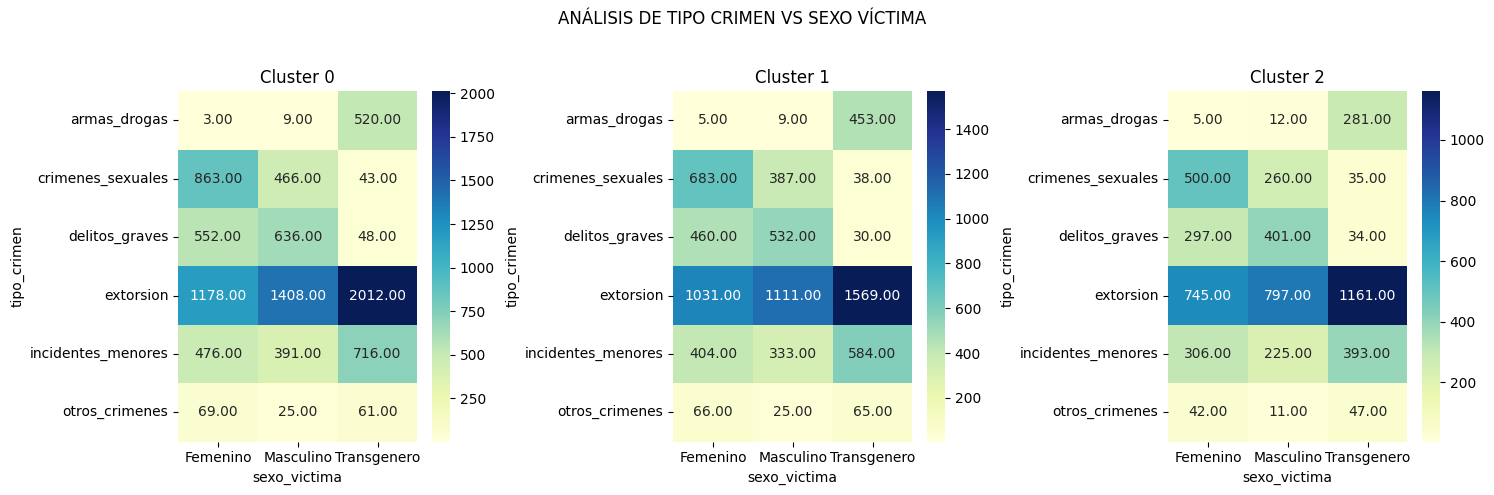

In [ ]:
manhattan_cluster_pca0 = manhattan_kmeans_con_reduccion[manhattan_kmeans_con_reduccion['clusters']==0]
manhattan_cluster_pca1 = manhattan_kmeans_con_reduccion[manhattan_kmeans_con_reduccion['clusters']==1]
manhattan_cluster_pca2 = manhattan_kmeans_con_reduccion[manhattan_kmeans_con_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_pca0['tipo_crimen'], manhattan_cluster_pca0['sexo_victima'])
ct1 = pd.crosstab(manhattan_cluster_pca1['tipo_crimen'], manhattan_cluster_pca1['sexo_victima'])
ct2 = pd.crosstab(manhattan_cluster_pca2['tipo_crimen'], manhattan_cluster_pca2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

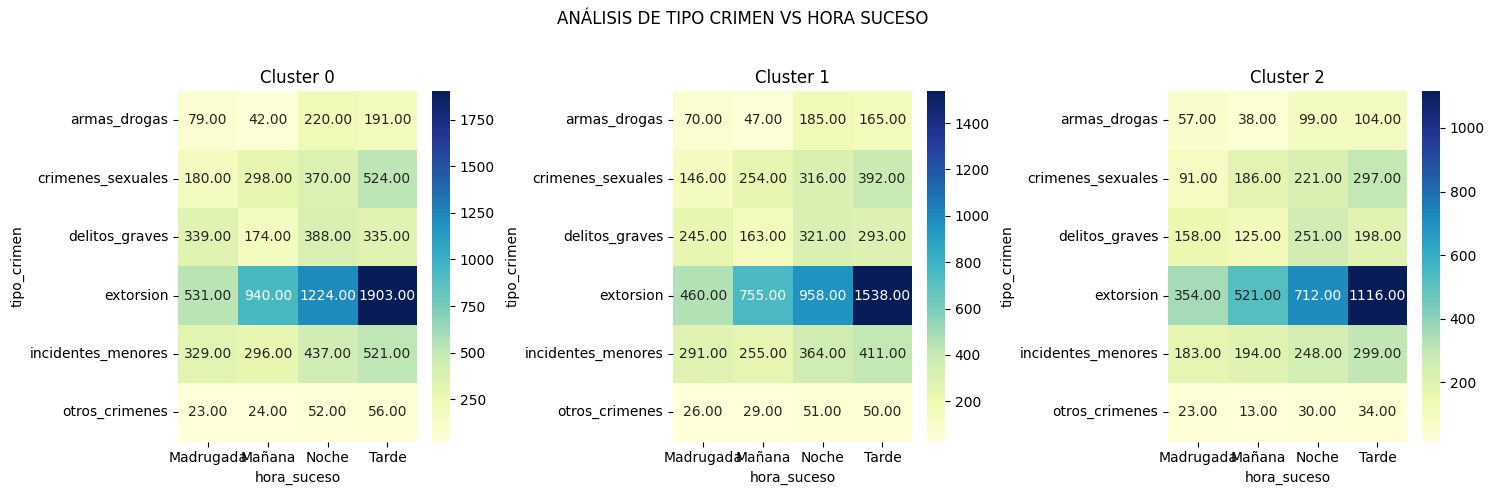

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(manhattan_cluster_pca0['tipo_crimen'], manhattan_cluster_pca0['hora_suceso'])
ct1 = pd.crosstab(manhattan_cluster_pca1['tipo_crimen'], manhattan_cluster_pca1['hora_suceso'])
ct2 = pd.crosstab(manhattan_cluster_pca2['tipo_crimen'], manhattan_cluster_pca2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

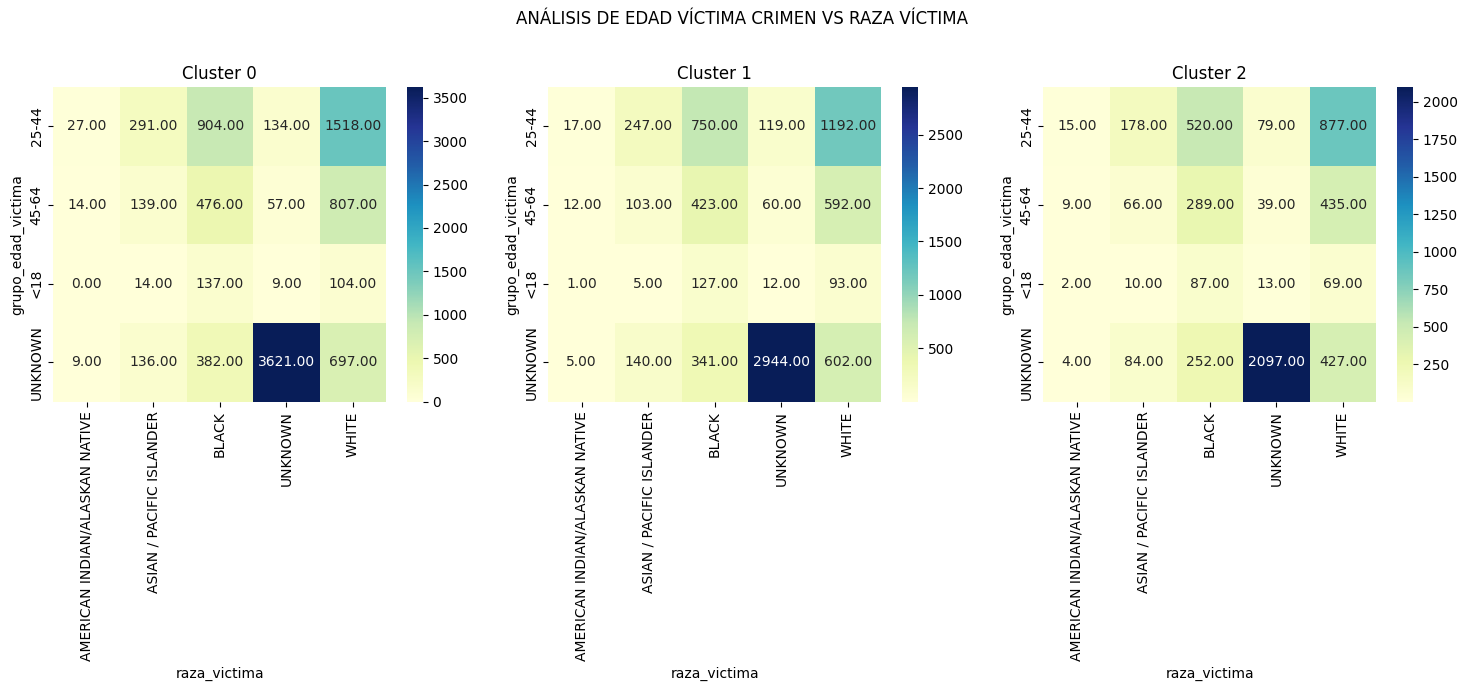

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_pca0['grupo_edad_victima'], manhattan_cluster_pca0['raza_victima'])
ct1 = pd.crosstab(manhattan_cluster_pca1['grupo_edad_victima'], manhattan_cluster_pca1['raza_victima'])
ct2 = pd.crosstab(manhattan_cluster_pca2['grupo_edad_victima'], manhattan_cluster_pca2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in manhattan_kmeans_con_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    display(manhattan_kmeans_sin_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'}))
    print('\n')

Variable hora_suceso:


,clusters,hora_suceso,casos
0,0,Madrugada,1273
1,0,Mañana,1584
2,0,Noche,2301
3,0,Tarde,3062
4,1,Madrugada,1073
5,1,Mañana,1265
6,1,Noche,1955
7,1,Tarde,2518
8,2,Madrugada,1239
9,2,Mañana,1505




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos
0,0,Externas,63
1,0,Otras,90
2,0,Policia,6865
3,0,Transito,436
4,0,Vivienda,766
5,1,Externas,64
6,1,Otras,71
7,1,Policia,5734
8,1,Transito,338
9,1,Vivienda,604




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos
0,0,25-44,2004
1,0,45-64,777
2,0,<18,194
3,0,UNKNOWN,5245
4,1,25-44,1690
5,1,45-64,666
6,1,<18,157
7,1,UNKNOWN,4298
8,2,25-44,1876
9,2,45-64,747




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,15
1,0,ASIAN / PACIFIC ISLANDER,151
2,0,BLACK,2643
3,0,UNKNOWN,3696
4,0,WHITE,1715
5,1,AMERICAN INDIAN/ALASKAN NATIVE,14
6,1,ASIAN / PACIFIC ISLANDER,145
7,1,BLACK,2214
8,1,UNKNOWN,3061
9,1,WHITE,1377




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos
0,0,Desconocido,3408
1,0,Femenino,1042
2,0,Masculino,3770
3,1,Desconocido,2839
4,1,Femenino,860
5,1,Masculino,3112
6,2,Desconocido,3233
7,2,Femenino,969
8,2,Masculino,3580




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos
0,0,25-44,2474
1,0,45-64,1278
2,0,<18,265
3,0,UNKNOWN,4203
4,1,25-44,2066
5,1,45-64,1062
6,1,<18,177
7,1,UNKNOWN,3506
8,2,25-44,2328
9,2,45-64,1181




Variable raza_victima:


,clusters,raza_victima,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,44
1,0,ASIAN / PACIFIC ISLANDER,495
2,0,BLACK,1686
3,0,UNKNOWN,3305
4,0,WHITE,2690
5,1,AMERICAN INDIAN/ALASKAN NATIVE,36
6,1,ASIAN / PACIFIC ISLANDER,424
7,1,BLACK,1367
8,1,UNKNOWN,2749
9,1,WHITE,2235




Variable sexo_victima:


,clusters,sexo_victima,casos
0,0,Femenino,2796
1,0,Masculino,2522
2,0,Transgenero,2902
3,1,Femenino,2241
4,1,Masculino,2119
5,1,Transgenero,2451
6,2,Femenino,2648
7,2,Masculino,2397
8,2,Transgenero,2737




Variable tipo_crimen:


,clusters,tipo_crimen,casos
0,0,armas_drogas,448
1,0,crimenes_sexuales,1164
2,0,delitos_graves,1084
3,0,extorsion,3988
4,0,incidentes_menores,1390
5,0,otros_crimenes,146
6,1,armas_drogas,388
7,1,crimenes_sexuales,1004
8,1,delitos_graves,879
9,1,extorsion,3310




Variable lugar:


,clusters,lugar,casos
0,0,Otros,279
1,0,diversion y turismo,2367
2,0,lugares publicos,4596
3,0,lugares solitarios,191
4,0,necesidades diarias,787
5,1,Otros,243
6,1,diversion y turismo,2009
7,1,lugares publicos,3802
8,1,lugares solitarios,159
9,1,necesidades diarias,598




Variable dia_suceso:


,clusters,dia_suceso,casos
0,0,domingo,1070
1,0,jueves,1222
2,0,lunes,1128
3,0,martes,1113
4,0,miercoles,1224
5,0,sabado,1180
6,0,viernes,1283
7,1,domingo,880
8,1,jueves,1011
9,1,lunes,892




Variable estacion_suceso:


,clusters,estacion_suceso,casos
0,0,invierno,1924
1,0,otono,2092
2,0,primavera,2040
3,0,verano,2164
4,1,invierno,1520
5,1,otono,1774
6,1,primavera,1697
7,1,verano,1820
8,2,invierno,1797
9,2,otono,1913




Variable mes_suceso:


,clusters,mes_suceso,casos
0,0,abril,649
1,0,agosto,729
2,0,diciembre,1350
3,0,febrero,661
4,0,julio,738
5,0,junio,723
6,0,marzo,581
7,0,mayo,668
8,0,noviembre,729
9,0,octubre,695


### **2 Sin reducción de dimensionalidad y aplicación de KModes.**

Se excluyen algunas variables para el análisis

In [ ]:
df_manhattan_ready.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)
df_manhattan_ready_sample.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


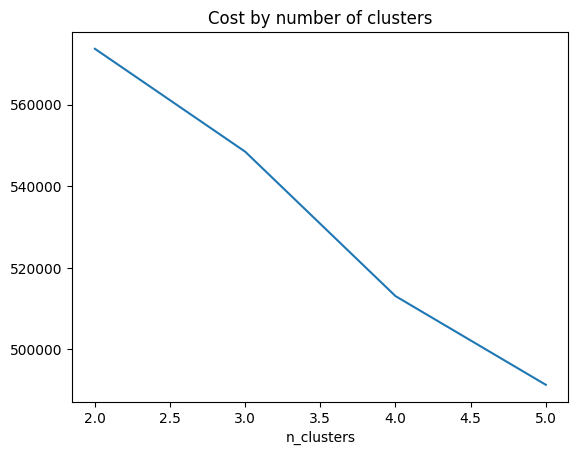

In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)

cost = []
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(categoricas_manhattan_encoded.sample(frac =0.2))
  cost.append(kmodes.cost_)

plt.title('Cost by number of clusters')
plt.xlabel('n_clusters')
plt.plot(n_clusters, cost)
plt.show()

In [ ]:
encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)
metrics_df_general_kmodes = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])

sample = categoricas_manhattan_encoded.sample(frac =0.5)
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(sample)
  labels = kmodes.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KModes'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_kmodes = metrics_df_general_kmodes.append(metrics_df, ignore_index=True)
metrics_df_general_kmodes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KModes,2,10457.160750,0.047752
1,KModes,3,8938.454738,0.042889
2,KModes,4,7065.145502,0.028536
3,KModes,5,6089.520113,0.012111


In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)

In [ ]:
kmodes = KModes(n_clusters=3, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
categoricas_manhattan_encoded2 = categoricas_manhattan_encoded.copy()
categoricas_manhattan_encoded2['labels'] = kmodes.fit_predict(categoricas_manhattan_encoded2)
categoricas_manhattan['labels']  = categoricas_manhattan_encoded2['labels'] 
categoricas_manhattan.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.


,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,jueves,primavera,abril,1
1,Noche,25-44,WHITE,Masculino,UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,sabado,verano,julio,1
2,Noche,<18,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,sabado,otono,diciembre,0
3,Mañana,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,extorsion,necesidades diarias,lunes,primavera,abril,0
4,Noche,25-44,BLACK,Desconocido,25-44,BLACK,Masculino,delitos_graves,lugares publicos,miercoles,otono,octubre,1


### Centroides en KModes

In [ ]:
pd.DataFrame(encoder.inverse_transform(kmodes.cluster_centroids_), columns = categoricas_manhattan_encoded.columns)

,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso
0,Tarde,UNKNOWN,UNKNOWN,Masculino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,viernes,otono,diciembre
1,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,extorsion,lugares publicos,miercoles,verano,julio
2,Mañana,UNKNOWN,WHITE,Masculino,25-44,WHITE,Masculino,crimenes_sexuales,lugares publicos,lunes,primavera,mayo


### Análisis de clusters en KModes

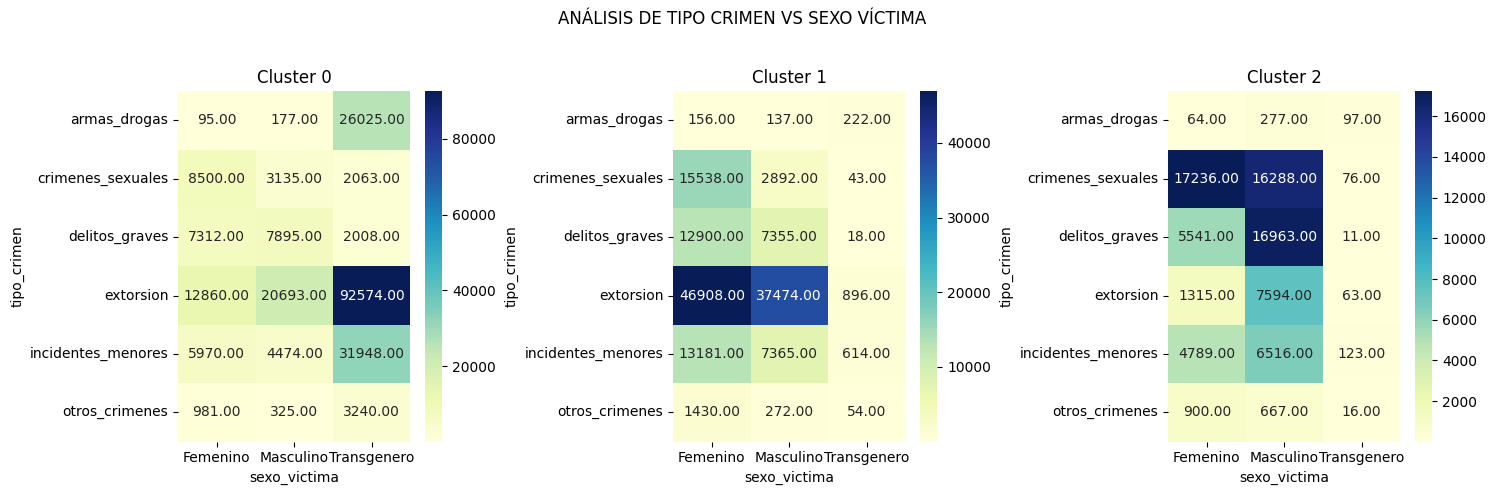

In [ ]:
manhattan_cluster_kmodes0 = categoricas_manhattan[categoricas_manhattan['labels']==0]
manhattan_cluster_kmodes1 = categoricas_manhattan[categoricas_manhattan['labels']==1]
manhattan_cluster_kmodes2 = categoricas_manhattan[categoricas_manhattan['labels']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['tipo_crimen'], manhattan_cluster_kmodes0['sexo_victima'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['tipo_crimen'], manhattan_cluster_kmodes1['sexo_victima'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['tipo_crimen'], manhattan_cluster_kmodes2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

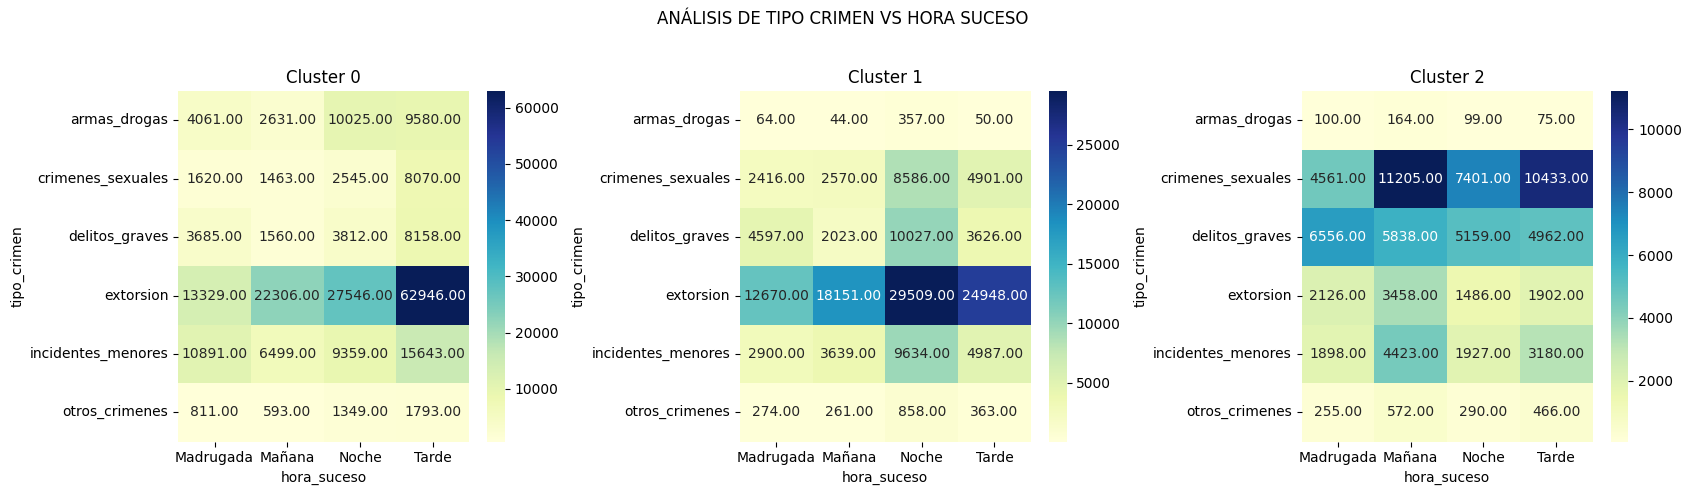

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (17,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['tipo_crimen'], manhattan_cluster_kmodes0['hora_suceso'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['tipo_crimen'], manhattan_cluster_kmodes1['hora_suceso'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['tipo_crimen'], manhattan_cluster_kmodes2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

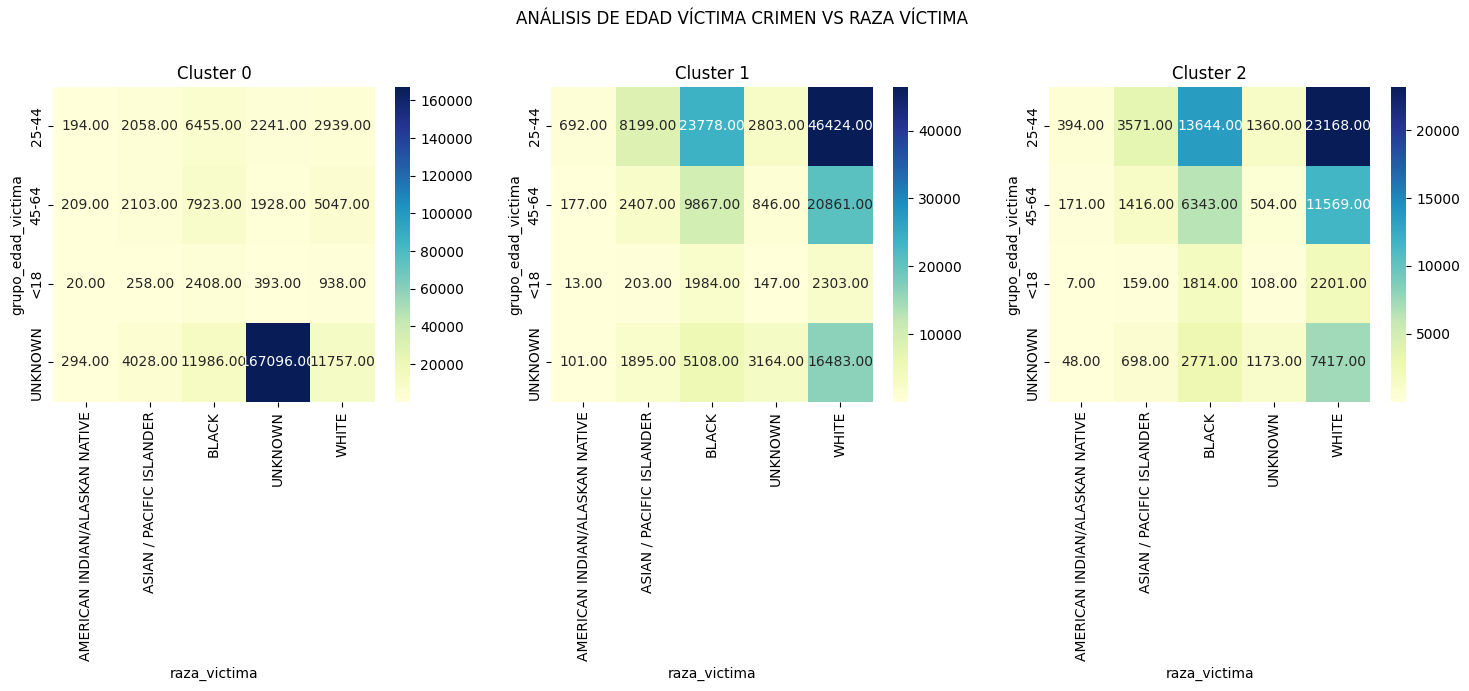

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['grupo_edad_victima'], manhattan_cluster_kmodes0['raza_victima'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['grupo_edad_victima'], manhattan_cluster_kmodes1['raza_victima'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['grupo_edad_victima'], manhattan_cluster_kmodes2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

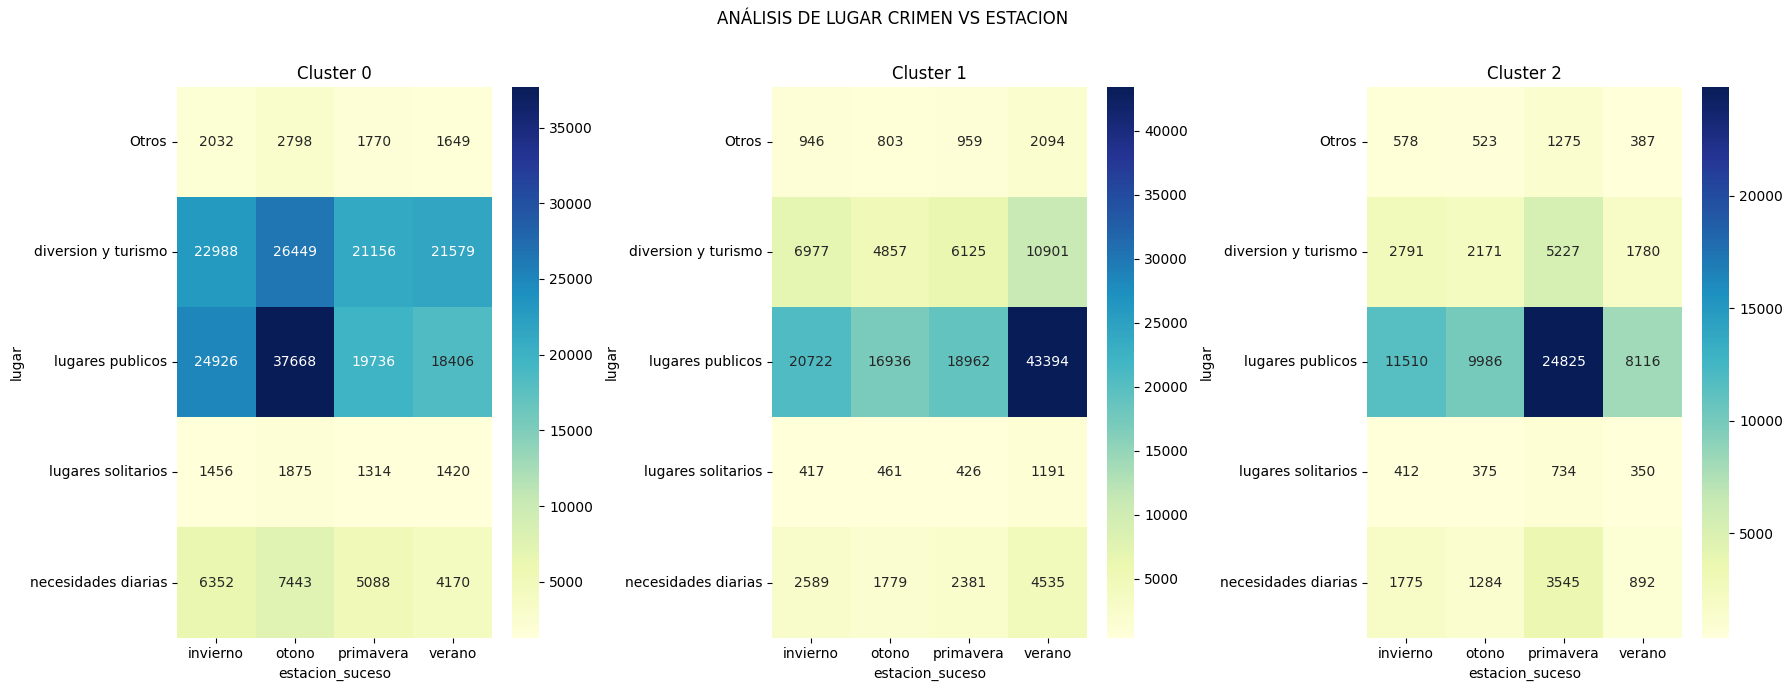

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,7))
fig.suptitle('ANÁLISIS DE LUGAR CRIMEN VS ESTACION \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['lugar'], manhattan_cluster_kmodes0['estacion_suceso'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['lugar'], manhattan_cluster_kmodes1['estacion_suceso'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['lugar'], manhattan_cluster_kmodes2['estacion_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in categoricas_manhattan.columns:
  if column not in ['labels', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    display(categoricas_manhattan.groupby(['labels', column]).size().reset_index().rename(columns = {0:'casos'}))
    print('\n')

Variable hora_suceso:


,labels,hora_suceso,casos
0,0,Madrugada,34397
1,0,Mañana,35052
2,0,Noche,54636
3,0,Tarde,106190
4,1,Madrugada,22921
5,1,Mañana,26688
6,1,Noche,58971
7,1,Tarde,38875
8,2,Madrugada,15496
9,2,Mañana,25660




Variable grupo_edad_sospechoso:


,labels,grupo_edad_sospechoso,casos
0,0,25-44,60739
1,0,45-64,25771
2,0,<18,5909
3,0,UNKNOWN,137856
4,1,25-44,18630
5,1,45-64,6103
6,1,<18,2044
7,1,UNKNOWN,120678
8,2,25-44,30489
9,2,45-64,11899




Variable raza_sospechoso:


,labels,raza_sospechoso,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,402
1,0,ASIAN / PACIFIC ISLANDER,4869
2,0,BLACK,88785
3,0,UNKNOWN,89282
4,0,WHITE,46937
5,1,AMERICAN INDIAN/ALASKAN NATIVE,179
6,1,ASIAN / PACIFIC ISLANDER,1647
7,1,BLACK,27495
8,1,UNKNOWN,105895
9,1,WHITE,12239




Variable sexo_sospechoso:


,labels,sexo_sospechoso,casos
0,0,Desconocido,80724
1,0,Femenino,26984
2,0,Masculino,122567
3,1,Desconocido,103428
4,1,Femenino,16997
5,1,Masculino,27030
6,2,Desconocido,4926
7,2,Femenino,14260
8,2,Masculino,59350




Variable grupo_edad_victima:


,labels,grupo_edad_victima,casos
0,0,25-44,13887
1,0,45-64,17210
2,0,<18,4017
3,0,UNKNOWN,195161
4,1,25-44,81896
5,1,45-64,34158
6,1,<18,4650
7,1,UNKNOWN,26751
8,2,25-44,42137
9,2,45-64,20003




Variable raza_victima:


,labels,raza_victima,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,717
1,0,ASIAN / PACIFIC ISLANDER,8447
2,0,BLACK,28772
3,0,UNKNOWN,171658
4,0,WHITE,20681
5,1,AMERICAN INDIAN/ALASKAN NATIVE,983
6,1,ASIAN / PACIFIC ISLANDER,12704
7,1,BLACK,40737
8,1,UNKNOWN,6960
9,1,WHITE,86071




Variable sexo_victima:


,labels,sexo_victima,casos
0,0,Femenino,35718
1,0,Masculino,36699
2,0,Transgenero,157858
3,1,Femenino,90113
4,1,Masculino,55495
5,1,Transgenero,1847
6,2,Femenino,29845
7,2,Masculino,48305
8,2,Transgenero,386




Variable tipo_crimen:


,labels,tipo_crimen,casos
0,0,armas_drogas,26297
1,0,crimenes_sexuales,13698
2,0,delitos_graves,17215
3,0,extorsion,126127
4,0,incidentes_menores,42392
5,0,otros_crimenes,4546
6,1,armas_drogas,515
7,1,crimenes_sexuales,18473
8,1,delitos_graves,20273
9,1,extorsion,85278




Variable lugar:


,labels,lugar,casos
0,0,Otros,8249
1,0,diversion y turismo,92172
2,0,lugares publicos,100736
3,0,lugares solitarios,6065
4,0,necesidades diarias,23053
5,1,Otros,4802
6,1,diversion y turismo,28860
7,1,lugares publicos,100014
8,1,lugares solitarios,2495
9,1,necesidades diarias,11284




Variable dia_suceso:


,labels,dia_suceso,casos
0,0,domingo,25976
1,0,jueves,35184
2,0,lunes,26998
3,0,martes,33750
4,0,miercoles,30868
5,0,sabado,32076
6,0,viernes,45423
7,1,domingo,19725
8,1,jueves,21453
9,1,lunes,17069




Variable estacion_suceso:


,labels,estacion_suceso,casos
0,0,invierno,57754
1,0,otono,76233
2,0,primavera,49064
3,0,verano,47224
4,1,invierno,31651
5,1,otono,24836
6,1,primavera,28853
7,1,verano,62115
8,2,invierno,17066
9,2,otono,14339




Variable mes_suceso:


,labels,mes_suceso,casos
0,0,abril,16658
1,0,agosto,16494
2,0,diciembre,50341
3,0,febrero,18734
4,0,julio,13458
5,0,junio,16984
6,0,marzo,16579
7,0,mayo,15422
8,0,noviembre,24654
9,0,octubre,23679
